# **Aleatoridad como estrategia**

In [2]:
import yfinance as yf
import pandas as pd
import random
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pypfopt.expected_returns import mean_historical_return

sns.set_palette("dark") 
warnings.filterwarnings("ignore")

---------
## **Simulador**

In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
import random
import requests
import warnings

from pypfopt.expected_returns import mean_historical_return
from bs4 import BeautifulSoup

sns.set_palette("dark")    # Tonos oscuros pero diferenciables (10 colores)
warnings.filterwarnings("ignore")

class PortafolioAleatorio:
    
    def __init__(self):
        self.all_symbols = self.obtener_simbolos()
        self.random_stocks = None
        self.prices = None
        self.start = None
        self.end = None
        self.pft_returns = None
        self.benchmark_returns = None
        
    def obtener_simbolos(self):
        sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
        stocks = sp500["Symbol"].tolist()
        stocks_yf = [s.replace('.', '-') for s in stocks]

        return stocks_yf

    def obtener_stocks_aleatorios(self, num_stocks=5):
        """
        Selecciona un número aleatorio de símbolos de acciones del NYSE.
        """
        self.random_stocks = random.choices(self.all_symbols, k=num_stocks)
        return self.random_stocks

    def precios_acciones_aleatorias(self, start, end):
        """
        Descarga los precios de cierre de los stocks aleatorios seleccionados.
        """
        if self.random_stocks is None:
            raise ValueError("Primero debes llamar a obtener_stocks_aleatorios()")
            
        self.end = end
        self.start = start
        self.prices = yf.download(
            tickers=self.random_stocks,
            start=self.start,
            end=self.end,
            interval = "1mo"
        )["Close"]
        return self.prices.dropna(axis = 1)
    def retornos_portafolio(self, start, end):
        """
		Calcula los retornos (sin mostrar gráfico) y devuelve el DataFrame
		"""
        if self.prices is None:
            self.precios_acciones_aleatorias(start = start, end = end)
        if self.benchmark_returns is None:
            sp500 = yf.download("^GSPC", start = start, end= end, interval= "1mo")["Close"]
            self.benchmark_returns = np.log(sp500 / sp500.shift(1)).dropna()
            self.benchmark_returns.rename(columns={"^GSPC": "SP500"}, inplace=True)
        weights = np.full(len(self.random_stocks), 1 / len(self.random_stocks))
        log_returns = np.log(self.prices / self.prices.shift(1)).dropna()
        self.pft_returns = pd.DataFrame(log_returns.dot(weights), columns=["Aleatorio"])
        return pd.concat([self.pft_returns, self.benchmark_returns], axis=1).dropna(axis = 1)
    
    def plot_retornos_portafolio(self):
        """
		Muestra el gráfico de retornos (requiere haber calculado antes los retornos)
		"""
        if self.pft_returns is None or self.benchmark_returns is None:
            returns = self.retornos_portafolio()
        else:
            returns = pd.concat([self.pft_returns, self.benchmark_returns], axis=1)
        print(f"Cada acción tiene un peso de: {1/len(self.random_stocks):.2%}")
        print(f"Acciones aleatorios: {self.random_stocks}")
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=returns, dashes=False)
        plt.ylim(top=.20, bottom=-.2)
        plt.title("Retornos", fontsize=20)
        plt.legend(title="Portafolio")
        plt.xlabel("")
        plt.ylabel("")
        plt.axhline(0, color = "black", lw = 1.5, alpha = .5, ls = "--")
        plt.tick_params("both", labelsize=13)
        plt.show()

    def valor_portafolio(self, investment=100):
        """
        Calcula el valor del portafolio a través del tiempo.
        """
        if self.pft_returns is None or self.benchmark_returns is None:
            self.retornos_portafolio()
            
        pf_price = (investment * (1 + (np.exp(self.pft_returns) - 1)).cumprod())
        pf_index = (investment * (1 + (np.exp(self.benchmark_returns) - 1)).cumprod())
        acumulados = pd.concat([pf_price, pf_index], axis=1)
        acumulados.columns = ["Aleatorio", "SP500"]
        
        n_valid_stocks = self.prices.dropna(axis=1).shape[1] if self.prices is not None else len(self.random_stocks)
        weights = np.full(n_valid_stocks, 1 / n_valid_stocks)

        print(f"Inversión inicial: {investment}")
        print(f"Valor final: {acumulados.iloc[-1,]}")
        print(f"Cada acción tiene un peso de: {weights[0]:.2%}")
        print(f"Acciones aleatorios: {self.random_stocks}")
        

        plt.figure(figsize=(10, 6))
        sns.lineplot(data=acumulados, dashes=False)
        plt.title("Valor del Portafolio", fontsize=20)
        plt.ylabel("")
        plt.xlabel("")
        plt.show()
        return acumulados

    def retornos_historicos(self):
        """
        Calcula los retornos históricos geómetricos del portafolio aleatorio y del benchmark (SP500).
        """ 
        if self.pft_returns is None or self.benchmark_returns is None:
            self.retornos_portafolio()
            
        historical_return_sp500 = mean_historical_return(
            prices=self.benchmark_returns,
            frequency=12,
            compounding=True,
            returns_data=True)[0]
            
        historical_returns_pf = mean_historical_return(
            prices=self.pft_returns,
            frequency=12,
            compounding=True,
            returns_data=True)[0]
        
        excess_return = historical_returns_pf - historical_return_sp500

        print(f"\tRetornos desde {self.start.date()} hasta {self.end.date()}\n{'-' * 57}")
        print(f"CARG Portafolio aleatorio: {historical_returns_pf:.2%}")
        print(f"CARG Portafolio SP500: {historical_return_sp500:.2%}")
        print(f"")
        print(f"Exceso de retorno: {historical_returns_pf - historical_return_sp500:.2%}")
        print(f"-" * 57 + f"\nAcciones aleatorias: {self.random_stocks}")
        print(f"Exceso de retorno: {excess_return:.2%}")
        
        return historical_returns_pf, historical_return_sp500, excess_return

In [371]:
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2025, 1, 1) 

p = PortafolioAleatorio()
p.obtener_stocks_aleatorios(10)
p.retornos_portafolio(start, end).head()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


,Aleatorio,SP500
Date,,
2020-02-01,-0.064199,-0.087860
2020-03-01,-0.187230,-0.133668
2020-04-01,0.133575,0.119421
2020-05-01,0.086926,0.044287
2020-06-01,0.024092,0.018221


In [406]:
num_stocks = 10
num_portafolios = 143
retornos_portafolios_aleatorios = pd.DataFrame()
max_intentos = 20
fecha = dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2025, 1, 1)   


print(f"Simulación hecha el día: {fecha}")

for i in range(num_portafolios):
	intento = 1
	portafolio_valido = False

	while intento <= max_intentos and not portafolio_valido:
		try:
			print(f"\nIntentando portafolio {i+1}, intento {intento}")

			p = PortafolioAleatorio()
			p.obtener_stocks_aleatorios(num_stocks)
			retornos = p.retornos_portafolio(start = start, end = end)
			
			if not retornos.empty and "Aleatorio" in retornos.columns:
				retornos_portafolios_aleatorios[f"Portafolio_{i+1}"] = retornos["Aleatorio"]
				retornos_portafolios_aleatorios["SP500"] = retornos["SP500"]
				portafolio_valido = True
				print(f"Portafolio_{i + 1} válido")

			else:
				raise ValueError(f"Datos incompletos: no hay datos disponibles para esas fecha")
			
		except Exception as e:
			print(f"Error en el intento {intento} para el portafolio {i+1}: {e}")
			intento += 1

	if not portafolio_valido:
		print(f"No se pudo obtener un portafolio válido para {i+1} después de {max_intentos} intentos")

print(f"\nPortafolios exitosos: {len(retornos_portafolios_aleatorios.columns) - 1}/{num_portafolios}")

# Eliminar columnas vacías
retornos_portafolios_aleatorios = retornos_portafolios_aleatorios.dropna(axis=1)



Simulación hecha el día: 2025-04-25 18:43:24

Intentando portafolio 1, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 1: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 1, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 2 para el portafolio 1: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 1, intento 3


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 3 para el portafolio 1: Dot product shape mismatch, (57, 9) vs (10,)

Intentando portafolio 1, intento 4


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_1 válido

Intentando portafolio 2, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_2 válido

Intentando portafolio 3, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_3 válido

Intentando portafolio 4, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_4 válido

Intentando portafolio 5, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_5 válido

Intentando portafolio 6, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_6 válido

Intentando portafolio 7, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_7 válido

Intentando portafolio 8, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 8: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 8, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_8 válido

Intentando portafolio 9, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_9 válido

Intentando portafolio 10, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_10 válido

Intentando portafolio 11, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 11: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 11, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_11 válido

Intentando portafolio 12, intento 1


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 12: Dot product shape mismatch, (35, 9) vs (10,)

Intentando portafolio 12, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_12 válido

Intentando portafolio 13, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_13 válido

Intentando portafolio 14, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_14 válido

Intentando portafolio 15, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_15 válido

Intentando portafolio 16, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_16 válido

Intentando portafolio 17, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_17 válido

Intentando portafolio 18, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_18 válido

Intentando portafolio 19, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_19 válido

Intentando portafolio 20, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_20 válido

Intentando portafolio 21, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_21 válido

Intentando portafolio 22, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 22: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 22, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 2 para el portafolio 22: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 22, intento 3


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_22 válido

Intentando portafolio 23, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 23: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 23, intento 2


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 2 para el portafolio 23: Dot product shape mismatch, (51, 9) vs (10,)

Intentando portafolio 23, intento 3


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 3 para el portafolio 23: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 23, intento 4


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_23 válido

Intentando portafolio 24, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 24: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 24, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_24 válido

Intentando portafolio 25, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 25: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 25, intento 2


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 2 para el portafolio 25: Dot product shape mismatch, (59, 9) vs (10,)

Intentando portafolio 25, intento 3


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_25 válido

Intentando portafolio 26, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_26 válido

Intentando portafolio 27, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_27 válido

Intentando portafolio 28, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_28 válido

Intentando portafolio 29, intento 1


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 29: Dot product shape mismatch, (59, 9) vs (10,)

Intentando portafolio 29, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_29 válido

Intentando portafolio 30, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_30 válido

Intentando portafolio 31, intento 1


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 31: Dot product shape mismatch, (59, 9) vs (10,)

Intentando portafolio 31, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_31 válido

Intentando portafolio 32, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 32: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 32, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_32 válido

Intentando portafolio 33, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_33 válido

Intentando portafolio 34, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_34 válido

Intentando portafolio 35, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 35: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 35, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_35 válido

Intentando portafolio 36, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_36 válido

Intentando portafolio 37, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_37 válido

Intentando portafolio 38, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_38 válido

Intentando portafolio 39, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_39 válido

Intentando portafolio 40, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_40 válido

Intentando portafolio 41, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_41 válido

Intentando portafolio 42, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_42 válido

Intentando portafolio 43, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 43: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 43, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 2 para el portafolio 43: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 43, intento 3


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 3 para el portafolio 43: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 43, intento 4


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_43 válido

Intentando portafolio 44, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_44 válido

Intentando portafolio 45, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_45 válido

Intentando portafolio 46, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_46 válido

Intentando portafolio 47, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 47: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 47, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_47 válido

Intentando portafolio 48, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_48 válido

Intentando portafolio 49, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_49 válido

Intentando portafolio 50, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_50 válido

Intentando portafolio 51, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_51 válido

Intentando portafolio 52, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_52 válido

Intentando portafolio 53, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_53 válido

Intentando portafolio 54, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_54 válido

Intentando portafolio 55, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_55 válido

Intentando portafolio 56, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_56 válido

Intentando portafolio 57, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_57 válido

Intentando portafolio 58, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 58: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 58, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_58 válido

Intentando portafolio 59, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 59: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 59, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_59 válido

Intentando portafolio 60, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_60 válido

Intentando portafolio 61, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 61: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 61, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_61 válido

Intentando portafolio 62, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_62 válido

Intentando portafolio 63, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_63 válido

Intentando portafolio 64, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_64 válido

Intentando portafolio 65, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_65 válido

Intentando portafolio 66, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_66 válido

Intentando portafolio 67, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_67 válido

Intentando portafolio 68, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_68 válido

Intentando portafolio 69, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 69: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 69, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_69 válido

Intentando portafolio 70, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 70: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 70, intento 2


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 2 para el portafolio 70: Dot product shape mismatch, (59, 9) vs (10,)

Intentando portafolio 70, intento 3


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_70 válido

Intentando portafolio 71, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_71 válido

Intentando portafolio 72, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_72 válido

Intentando portafolio 73, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_73 válido

Intentando portafolio 74, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_74 válido

Intentando portafolio 75, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_75 válido

Intentando portafolio 76, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_76 válido

Intentando portafolio 77, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_77 válido

Intentando portafolio 78, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_78 válido

Intentando portafolio 79, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_79 válido

Intentando portafolio 80, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_80 válido

Intentando portafolio 81, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_81 válido

Intentando portafolio 82, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_82 válido

Intentando portafolio 83, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_83 válido

Intentando portafolio 84, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_84 válido

Intentando portafolio 85, intento 1


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 85: Dot product shape mismatch, (59, 9) vs (10,)

Intentando portafolio 85, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_85 válido

Intentando portafolio 86, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_86 válido

Intentando portafolio 87, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_87 válido

Intentando portafolio 88, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_88 válido

Intentando portafolio 89, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_89 válido

Intentando portafolio 90, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_90 válido

Intentando portafolio 91, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_91 válido

Intentando portafolio 92, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_92 válido

Intentando portafolio 93, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 93: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 93, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_93 válido

Intentando portafolio 94, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_94 válido

Intentando portafolio 95, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_95 válido

Intentando portafolio 96, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_96 válido

Intentando portafolio 97, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 97: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 97, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 2 para el portafolio 97: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 97, intento 3


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_97 válido

Intentando portafolio 98, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_98 válido

Intentando portafolio 99, intento 1


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 99: Dot product shape mismatch, (59, 9) vs (10,)

Intentando portafolio 99, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_99 válido

Intentando portafolio 100, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_100 válido

Intentando portafolio 101, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_101 válido

Intentando portafolio 102, intento 1


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 102: Dot product shape mismatch, (59, 9) vs (10,)

Intentando portafolio 102, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_102 válido

Intentando portafolio 103, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_103 válido

Intentando portafolio 104, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_104 válido

Intentando portafolio 105, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_105 válido

Intentando portafolio 106, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_106 válido

Intentando portafolio 107, intento 1


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 107: Dot product shape mismatch, (59, 9) vs (10,)

Intentando portafolio 107, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 2 para el portafolio 107: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 107, intento 3


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_107 válido

Intentando portafolio 108, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 108: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 108, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 2 para el portafolio 108: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 108, intento 3


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 3 para el portafolio 108: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 108, intento 4


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_108 válido

Intentando portafolio 109, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_109 válido

Intentando portafolio 110, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_110 válido

Intentando portafolio 111, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 111: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 111, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_111 válido

Intentando portafolio 112, intento 1


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 112: Dot product shape mismatch, (59, 9) vs (10,)

Intentando portafolio 112, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_112 válido

Intentando portafolio 113, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_113 válido

Intentando portafolio 114, intento 1


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 114: Dot product shape mismatch, (48, 9) vs (10,)

Intentando portafolio 114, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_114 válido

Intentando portafolio 115, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_115 válido

Intentando portafolio 116, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_116 válido

Intentando portafolio 117, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_117 válido

Intentando portafolio 118, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_118 válido

Intentando portafolio 119, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 119: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 119, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_119 válido

Intentando portafolio 120, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_120 válido

Intentando portafolio 121, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 121: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 121, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_121 válido

Intentando portafolio 122, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_122 válido

Intentando portafolio 123, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_123 válido

Intentando portafolio 124, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_124 válido

Intentando portafolio 125, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_125 válido

Intentando portafolio 126, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_126 válido

Intentando portafolio 127, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_127 válido

Intentando portafolio 128, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 128: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 128, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_128 válido

Intentando portafolio 129, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_129 válido

Intentando portafolio 130, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_130 válido

Intentando portafolio 131, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_131 válido

Intentando portafolio 132, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 132: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 132, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_132 válido

Intentando portafolio 133, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 133: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 133, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 2 para el portafolio 133: Datos incompletos: no hay datos disponibles para esas fecha

Intentando portafolio 133, intento 3


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_133 válido

Intentando portafolio 134, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_134 válido

Intentando portafolio 135, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_135 válido

Intentando portafolio 136, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_136 válido

Intentando portafolio 137, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_137 válido

Intentando portafolio 138, intento 1


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 138: Dot product shape mismatch, (59, 9) vs (10,)

Intentando portafolio 138, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_138 válido

Intentando portafolio 139, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_139 válido

Intentando portafolio 140, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_140 válido

Intentando portafolio 141, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_141 válido

Intentando portafolio 142, intento 1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Portafolio_142 válido

Intentando portafolio 143, intento 1


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Error en el intento 1 para el portafolio 143: Dot product shape mismatch, (46, 9) vs (10,)

Intentando portafolio 143, intento 2


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed

Portafolio_143 válido

Portafolios exitosos: 143/143


In [450]:
retornos_portafolios_aleatorios.head()

,Portafolio_1,SP500,Portafolio_2,Portafolio_3,Portafolio_4,Portafolio_5,Portafolio_6,Portafolio_7,Portafolio_8,Portafolio_9,...,Portafolio_134,Portafolio_135,Portafolio_136,Portafolio_137,Portafolio_138,Portafolio_139,Portafolio_140,Portafolio_141,Portafolio_142,Portafolio_143
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,-0.069329,-0.087860,-0.082746,-0.096678,-0.094410,-0.085394,-0.126753,-0.098453,-0.092219,-0.086318,...,-0.078021,-0.069046,-0.110381,-0.079748,-0.077370,-0.082933,-0.066503,-0.052487,-0.104072,-0.103101
2020-03-01,-0.235614,-0.133668,-0.274542,-0.251442,-0.461358,-0.199583,-0.294265,-0.215292,-0.232404,-0.213659,...,-0.284688,-0.139527,-0.103322,-0.264467,-0.153992,-0.174596,-0.134630,-0.119217,-0.310773,-0.146254
2020-04-01,0.154360,0.119421,0.160373,0.162542,0.204569,0.106129,0.161308,0.128777,0.118707,0.110241,...,0.239367,0.093879,0.134801,0.119967,0.121351,0.127505,0.136122,0.113904,0.151116,0.087301
2020-05-01,0.056137,0.044287,0.063330,0.065968,-0.004665,0.014227,0.032187,0.045132,0.033219,0.045626,...,0.011447,0.076573,0.044607,0.054013,0.064267,0.079771,0.071797,0.059401,0.053257,0.061812
2020-06-01,0.006064,0.018221,0.035108,-0.016718,0.051678,0.058819,0.004592,0.011527,0.012949,0.029356,...,0.015276,0.029927,-0.018081,0.038754,0.023824,-0.009769,-0.021957,-0.027511,-0.029822,0.031145


In [451]:
retornos_portafolios_aleatorios.to_csv("portafolios_aleatorios.csv", index = True)

In [5]:
random_portfs = pd.read_csv("C:\\Users\\kike\\OneDrive - Universidad de Alcala\\Documentos\\Entorno Jupyter\\Proyectos y prácticas\\Articulo\\portafolios_aleatorios.csv")
random_portfs.set_index("Date", inplace = True)
random_portfs = random_portfs.iloc[1:]
del random_portfs["Portafolio_143"]
random_portfs.head()

,Portafolio_1,SP500,Portafolio_2,Portafolio_3,Portafolio_4,Portafolio_5,Portafolio_6,Portafolio_7,Portafolio_8,Portafolio_9,...,Portafolio_133,Portafolio_134,Portafolio_135,Portafolio_136,Portafolio_137,Portafolio_138,Portafolio_139,Portafolio_140,Portafolio_141,Portafolio_142
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,-0.235614,-0.133668,-0.274542,-0.251442,-0.461358,-0.199583,-0.294265,-0.215292,-0.232404,-0.213659,...,-0.280464,-0.284688,-0.139527,-0.103322,-0.264467,-0.153992,-0.174596,-0.134630,-0.119217,-0.310773
2020-04-01,0.154360,0.119421,0.160373,0.162542,0.204569,0.106129,0.161308,0.128777,0.118707,0.110241,...,0.127005,0.239367,0.093879,0.134801,0.119967,0.121351,0.127505,0.136122,0.113904,0.151116
2020-05-01,0.056137,0.044287,0.063330,0.065968,-0.004665,0.014227,0.032187,0.045132,0.033219,0.045626,...,0.050976,0.011447,0.076573,0.044607,0.054013,0.064267,0.079771,0.071797,0.059401,0.053257
2020-06-01,0.006064,0.018221,0.035108,-0.016718,0.051678,0.058819,0.004592,0.011527,0.012949,0.029356,...,0.047202,0.015276,0.029927,-0.018081,0.038754,0.023824,-0.009769,-0.021957,-0.027511,-0.029822
2020-07-01,0.058567,0.053637,0.033314,0.018600,0.056504,0.061311,0.065315,0.035483,0.026477,0.039573,...,0.047874,0.070110,0.040493,0.088527,0.029375,0.020032,0.038287,0.073446,0.090921,0.036246


In [6]:
import numpy as np
import pandas as pd

def sharpe_ratio(returns, log=False, risk_free=0, frequency=252):
    """
    Calcula el Sharpe Ratio anualizado para Series de pandas.

    Parámetros:
    - returns: Serie de retornos (pandas Series).
    - log: True si son retornos logarítmicos.
    - risk_free: Tasa libre de riesgo anualizada.
    - frequency: Número de períodos por año.
    """
    if returns.empty:
        return pd.Series([np.nan], name="sharpe_ratio")
    
    # 1. Calcular retorno anualizado
    if log:
        cumulative_return = returns.sum()
        annualized_return = np.exp(cumulative_return * (frequency / len(returns))) - 1
    else:
        annualized_return = (1 + returns.mean())**frequency - 1
    
    # 2. Calcular volatilidad anualizada
    annualized_volatility = returns.std() * np.sqrt(frequency)
    
    # Verificar si HAY ALGÚN cero en la volatilidad (usar .any() para Series)
    if (annualized_volatility == 0).any():
        return pd.Series([np.nan], name="sharpe_ratio")
    
    # 3. Calcular Sharpe Ratio
    sharpe = (annualized_return - risk_free) / annualized_volatility
    
    return pd.Series(sharpe, name="sharpe_ratio")

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

def jensen_alpha(returns, market_returns, risk_free = 2, log=False, frequency = 252):
    """
    Calcula el Alpha de Jensen.

    Parámetros:
    - returns: Retornos del portafolio (Serie o DataFrame).
    - market_returns: Retornos del benchmark (Serie).
    - risk_free: Tasa libre de riesgo anualizada (ej. 0.02 para 2%).
    - log: Si True, los retornos son logarítmicos.
    - frequency: Número de períodos por año (12 para mensual, 252 para diario).

    Retorna:
    - pd.Series con el Jensen's Alpha anualizado.
    """
    # Validación
    if len(returns) != len(market_returns):
        raise ValueError("'returns' y 'market_returns' deben tener la misma longitud.")

    # Convertir retornos logarítmicos a aritméticos para la regresión
    if log:
        returns_reg = np.exp(returns) - 1
        market_reg = np.exp(market_returns) - 1
    else:
        returns_reg = returns
        market_reg = market_returns

    # Calcular Beta y Alpha (regresión lineal)
    excess_returns = returns_reg - risk_free / frequency
    excess_market = market_reg - risk_free / frequency

    if isinstance(returns, pd.DataFrame):
        alpha = excess_returns.apply(lambda col: linregress(excess_market, col)[1]) * frequency
        alpha.name = "jensen_alpha"
    else:
        alpha = pd.Series(
            linregress(excess_market, excess_returns)[1] * frequency,
            name="jensen_alpha"
        )

    return alpha

			Métricas
---------------------------------------------------------
El CARG medio de los portafolios aleatorios: 9.61%
El CARG del SP500: 13.41%
Exceso de retorno: -3.80%
Beta media de los portafolios aleatorios: 1.10
Volatilidad media de los portafolios aleatorios: 21.75%
Volatilidad del SP500: 17.80%
Sharpe Ratio promedio de los portafolio aleatorios: 0.48
Alpha promedio de los portafolios aleatorios: 0.11
---------------------------------------------------------
Número de portafolios aleatorios: 142
Número de portafolio aleatorios que han batido el SP500: 26/142


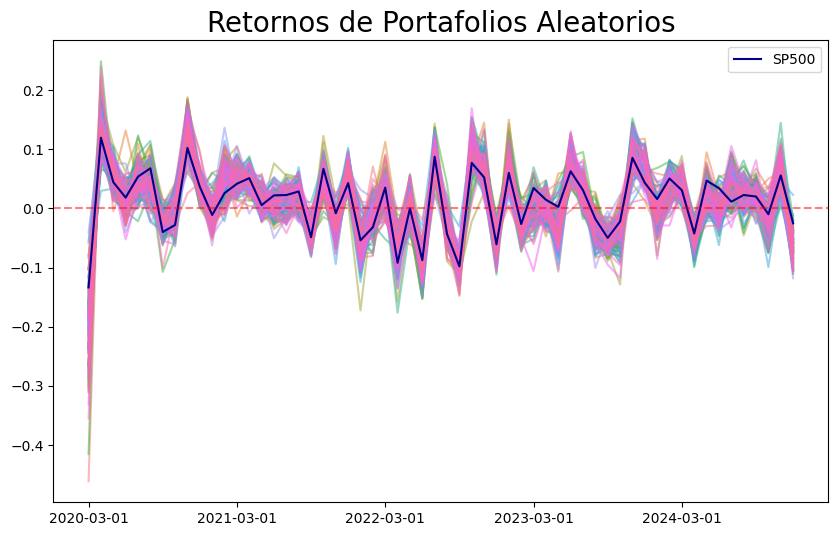

In [8]:
from pypfopt.expected_returns import mean_historical_return


# Calculamos el CARG de cada portafolio aleatorio y el de SP500
carg_sp500 = mean_historical_return(
    prices = random_portfs["SP500"],
    frequency = 12,
    compounding = True,
    returns_data = True
)[0]

cargs_returns = []
for portafolio in random_portfs.columns:
    if portafolio != "SP500":
        historical_returns = mean_historical_return(
            prices = random_portfs[portafolio],
            frequency = 12,
            compounding = True,
            returns_data = True
		)[0] 
        cargs_returns.append(historical_returns)

# Hallamos el CARG medio de los portafolios aleatorios        
carg_returns = np.array(cargs_returns)
carg_returns_mean = carg_returns.mean()

print("\t\t\tMétricas")
print("-" * 57)
print(f"El CARG medio de los portafolios aleatorios: {carg_returns_mean:.2%}")
print(f"El CARG del SP500: {carg_sp500:.2%}")
print(f"Exceso de retorno: {carg_returns_mean - carg_sp500:.2%}")

# La beta de cada portafolio
betas = []

for portafolio in random_portfs.columns:
    if portafolio != "SP500":
        beta = np.cov(random_portfs[portafolio], random_portfs["SP500"])[0][1] / np.var(random_portfs["SP500"])
        betas.append(beta)
print(f"Beta media de los portafolios aleatorios: {np.mean(betas):.2f}")


# Volatilidad de cada portafolio

vols = []
for portafolio in random_portfs.columns:
    if portafolio != "SP500":
        vol = np.std(random_portfs[portafolio]) * np.sqrt(12)
        vols.append(vol)
print(f"Volatilidad media de los portafolios aleatorios: {np.mean(vols):.2%}")
print(f"Volatilidad del SP500: {np.std(random_portfs["SP500"]) * np.sqrt(12):.2%}")
    

# El Sharpe Ratio y alpha
sharpe_ratios = []
for portafolio in random_portfs:
    if portafolio != "SP500":
        porft_sharpe = sharpe_ratio(returns = random_portfs, 
					log = True, 
					risk_free = .02,
					frequency = 12)
        sharpe_ratios.append(porft_sharpe)
sharpe_ratio_mean = np.mean(sharpe_ratios)
print(f"Sharpe Ratio promedio de los portafolio aleatorios: {sharpe_ratio_mean:.2f}")

porft_alphas = []
for portafolio in random_portfs:
    if portafolio != "SP500":
        alpha = jensen_alpha(returns = random_portfs[portafolio],
                            market_returns = random_portfs["SP500"],
                            log = True,
                            frequency = 12)[0]
        porft_alphas.append(alpha)
porft_alphas_mean = np.mean(porft_alphas)
print(f"Alpha promedio de los portafolios aleatorios: {porft_alphas_mean:.2f}")

print("-" * 57)
print(f"Número de portafolios aleatorios: {len(random_portfs.columns) - 1}")
print(f"Número de portafolio aleatorios que han batido el SP500: {(carg_returns > carg_sp500).sum()}/{len(carg_returns)}")


plt.figure(figsize = (10, 6))
sns.lineplot(data = random_portfs,
            dashes = False, 
            alpha = .5,
            legend = False)
sns.lineplot(data = random_portfs["SP500"],
            dashes = False,
            color = "darkblue",
            lw = 1.5,
            label = "SP500", legend = True)
plt.xticks(random_portfs.index[::12])
plt.title("Retornos de Portafolios Aleatorios", fontsize = 20)
plt.ylabel("")
plt.legend(loc = "upper right")
plt.xlabel("")
plt.axhline(0, color = "red", lw = 1.5, alpha = .5, ls = "--")
plt.show()


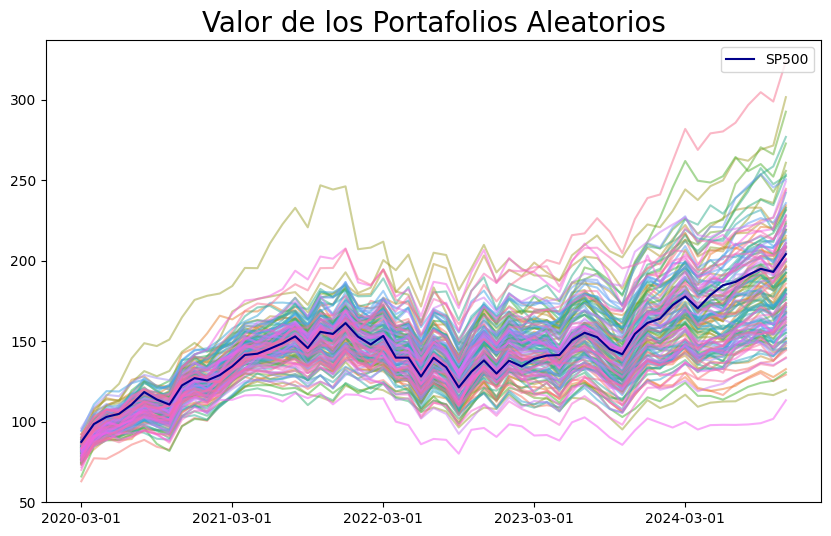

In [411]:
# Inversión
investment = 100

values_across_time = investment * (1 + (np.exp(random_portfs) -1)).cumprod()

sns.lineplot(values_across_time,
            dashes = False, 
            legend = False,
            alpha = .5)
sns.lineplot(values_across_time["SP500"], 
            label = "SP500",
            color = "darkblue",
            lw = 1.5,)
sns.lineplot()
# sns.lineplot(data = pf_index)
# sns.lineplot(data  = pf_price, label = "Aleatorio")
plt.title("Valor de los Portafolios Aleatorios", fontsize = 20)
plt.ylabel("")
plt.xlabel("")
plt.legend(loc = "upper right")
plt.xticks(values_across_time.index[::12])
plt.gcf().set_size_inches(10, 6)

*****************
## **Para ETF gestionados activamente**

In [3]:
# Vemos los precios de etfs
etfs = pd.read_csv("C:\\Users\\kike\\OneDrive - Universidad de Alcala\\Documentos\\Entorno Jupyter\\Proyectos y prácticas\\Articulo\\prices_etf.csv")
etfs.set_index("Date", inplace = True)

# Retornos 
log_returns_etfs = np.log(etfs / etfs.shift(1)).dropna()
log_returns_etfs = log_returns_etfs.dropna(axis = 1)
print(log_returns_etfs.shape)

(58, 143)


			Métricas
---------------------------------------------------------
El CARG medio de los ETFs: 6.50%
El CARG del SP500: 13.41%
Exceso de retorno: -6.91%
Beta media de los ETF: 0.84
Volatilidad media de los ETFs: 19.31%
Volatilidad del SP500: 17.80%
Sharpe Ratio promedio de los ETFs: 0.46
Sharpe Ratio del SP500: 0.74
Alpha promedio de los ETFs: -0.38
---------------------------------------------------------
Número de ETFs: 142
Número de ETFs que han superado el SP500: 19/142


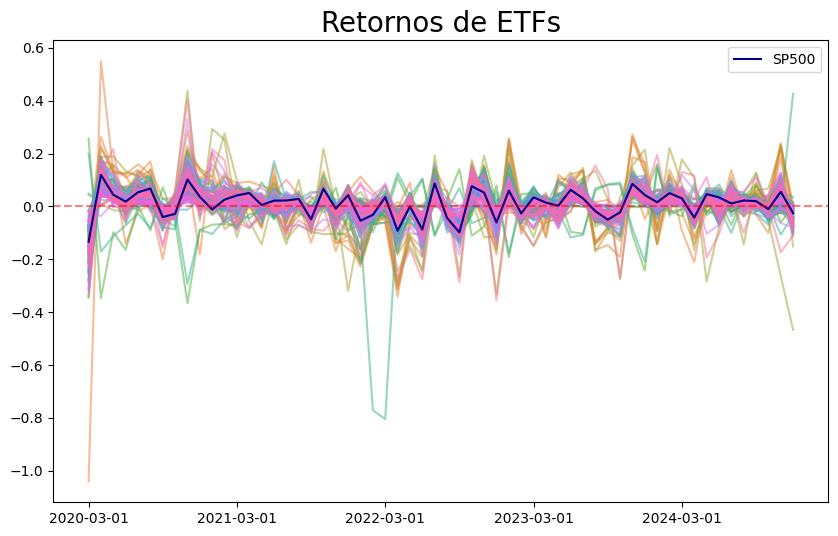

In [9]:
# Evaluamos los ETFs en su conjunto

cargs_returns_etfs = []
for etf in log_returns_etfs.columns:
	historical_returns_etf = mean_historical_return(
		prices = log_returns_etfs[etf],
		frequency = 12,
		compounding = True,
		returns_data = True
	)[0] 
	if not np.isnan(historical_returns_etf):
		cargs_returns_etfs.append(historical_returns_etf)

# Hallamos el CARG medio de los portafolios aleatorios        
cargs_returns_etfs = np.array(cargs_returns_etfs)
carg_returns_etfs_mean = cargs_returns_etfs.mean()

print("\t\t\tMétricas")
print("-" * 57)
print(f"El CARG medio de los ETFs: {carg_returns_etfs_mean:.2%}")
print(f"El CARG del SP500: {carg_sp500:.2%}")
print(f"Exceso de retorno: {carg_returns_etfs_mean - carg_sp500:.2%}")

# La beta de cada portafolio
betas_etfs = []

for etf in log_returns_etfs.columns:
	beta_etf = np.cov(log_returns_etfs[etf], random_portfs["SP500"])[0][1] / np.var(random_portfs["SP500"])
	betas_etfs.append(beta_etf)
print(f"Beta media de los ETF: {np.mean(betas_etfs):.2f}")


# Volatilidad de cada portafolio

vols_etfs = []
for etf in log_returns_etfs.columns:
	vols_etf = np.std(log_returns_etfs[etf]) * np.sqrt(12)
	vols_etfs.append(vols_etf)
print(f"Volatilidad media de los ETFs: {np.mean(vols_etfs):.2%}")
print(f"Volatilidad del SP500: {np.std(random_portfs["SP500"]) * np.sqrt(12):.2%}")

# El Sharpe Ratio y alpha
sharpe_ratios_etfs = []
for etf in log_returns_etfs:
    porft_sharpe_etf = sharpe_ratio(returns = log_returns_etfs[etf], 
					log = True, 
					risk_free = .02,
					frequency = 12)
    sharpe_ratios_etfs.append(porft_sharpe_etf)
sharpe_ratio_mean_etfs = np.mean(sharpe_ratios_etfs)

sharpe_ratio_sp500 = sharpe_ratio(returns = random_portfs["SP500"],
								log = True,
								risk_free = .02,
								frequency = 12)[0]
print(f"Sharpe Ratio promedio de los ETFs: {sharpe_ratio_mean_etfs:.2f}")
print(f"Sharpe Ratio del SP500: {sharpe_ratio_sp500:.2f}")
etfs_alphas = []
for etf in log_returns_etfs:
	alpha = jensen_alpha(returns = log_returns_etfs[etf],
						market_returns = random_portfs["SP500"],
						log = True,
						frequency = 12)[0]
	etfs_alphas.append(alpha)
etf_alphas_mean = np.mean(etfs_alphas)
print(f"Alpha promedio de los ETFs: {etf_alphas_mean:.2f}")
    

print("-" * 57)
print(f"Número de ETFs: {len(log_returns_etfs.columns) - 1}")
print(f"Número de ETFs que han superado el SP500: {(cargs_returns_etfs > carg_sp500).sum()}/{len(cargs_returns_etfs)}")

plt.figure(figsize = (10, 6))
sns.lineplot(data = log_returns_etfs,
            dashes = False, 
            alpha = .5,
            legend = False)
sns.lineplot(data = random_portfs["SP500"],
            dashes = False,
            color = "darkblue",
            lw = 1.5,
            label = "SP500", legend = True)
plt.xticks(log_returns_etfs.index[::12])
plt.title("Retornos de ETFs", fontsize = 20)
plt.ylabel("")
plt.legend(loc = "upper right")
plt.xlabel("")
plt.axhline(0, color = "red", lw = 1.5, alpha = .5, ls = "--")
plt.show()

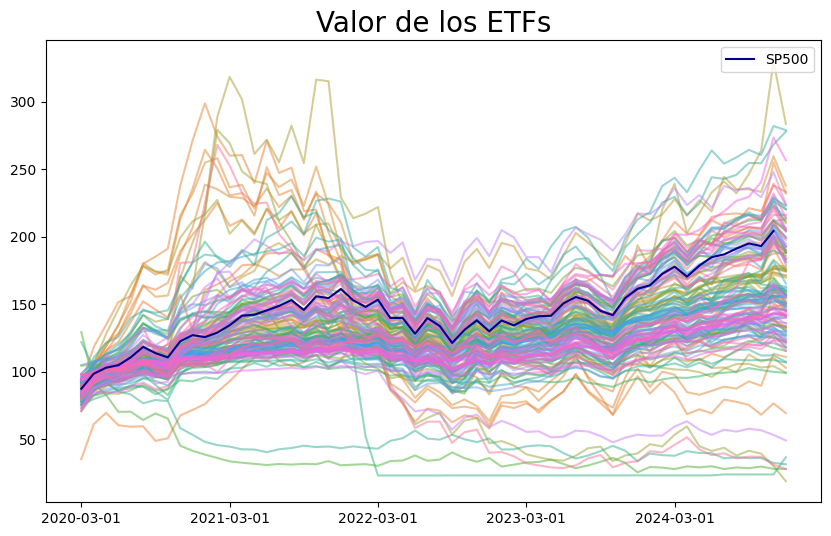

In [467]:
# Inversión
investment = 100

values_across_time_etf = investment * (1 + (np.exp(log_returns_etfs) -1)).cumprod()

sns.lineplot(values_across_time_etf,
            dashes = False, 
            legend = False,
            alpha = .5)
sns.lineplot(values_across_time["SP500"], 
            label = "SP500",
            color = "darkblue",
            lw = 1.5,)
sns.lineplot()
# sns.lineplot(data = pf_index)
# sns.lineplot(data  = pf_price, label = "Aleatorio")
plt.title("Valor de los ETFs", fontsize = 20)
plt.ylabel("")
plt.xlabel("")
plt.legend(loc = "upper right")
plt.xticks(values_across_time.index[::12])
plt.gcf().set_size_inches(10, 6)